In [30]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os
import pandas as pd
import numpy as np
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, GlobalMaxPooling2D, AveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import img_to_array
import tensorflow as tf

In [ ]:
# ResNet50을 이용한 이미지 분류(Binary classification)
# Kaggle에서 데이터를 다운로드합니다.

drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
# !unzip tuberculosis-tb-chest-xray-dataset.zip
!unzip covid19-radiography-database.zip

In [3]:
# Labeling

path_normal = '/content/COVID-19_Radiography_Dataset/Normal/images'
path_covid = '/content/COVID-19_Radiography_Dataset/COVID/images'
path_opacity = '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images'
path_pneumonia = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

filenames = os.listdir(path_normal) + os.listdir(path_opacity) + os.listdir(path_pneumonia)# + os.listdir(path_covid) 
labels = []

for filename in filenames:
  state = filename.split('-')[0]

  if state == 'Normal':
    labels.append('0')
  # elif state == 'COVID':
  #   labels.append('1')
  elif state == 'Lung_Opacity':
    labels.append('1')
  else:
    labels.append('2')

len(filenames) == len(labels)

True

In [4]:
# # Labeling

# path_normal = '/content/TB_Chest_Radiography_Database/Normal'
# path_tuberculosis = '/content/TB_Chest_Radiography_Database/Tuberculosis'

# filenames = os.listdir(path_normal) + os.listdir(path_tuberculosis)
# labels = []

# for filename in filenames:
#   state = filename.split('-')[0]

#   if state == 'Normal':
#     labels.append('0')
#   else:
#     labels.append('1')

# len(filenames) == len(labels)

In [5]:
for i in range(len(labels)):
  if labels[i] == '0':
    filenames[i] = os.path.join(path_normal, filenames[i])
  # elif labels[i] == '1':
  #   filenames[i] = os.path.join(path_covid, filenames[i])
  elif labels[i] == '1':
    filenames[i] = os.path.join(path_opacity, filenames[i])
  else:
    filenames[i] = os.path.join(path_pneumonia, filenames[i])

df = pd.DataFrame({'filename': filenames, 'label': labels})
df

,filename,label
0,/content/COVID-19_Radiography_Dataset/Normal/i...,0
1,/content/COVID-19_Radiography_Dataset/Normal/i...,0
2,/content/COVID-19_Radiography_Dataset/Normal/i...,0
3,/content/COVID-19_Radiography_Dataset/Normal/i...,0
4,/content/COVID-19_Radiography_Dataset/Normal/i...,0
...,...,...
17544,/content/COVID-19_Radiography_Dataset/Viral Pn...,2
17545,/content/COVID-19_Radiography_Dataset/Viral Pn...,2
17546,/content/COVID-19_Radiography_Dataset/Viral Pn...,2
17547,/content/COVID-19_Radiography_Dataset/Viral Pn...,2


In [6]:
df.label.value_counts()

0    10192
1     6012
2     1345
Name: label, dtype: int64

In [7]:
df.label.value_counts(normalize=True)

0    0.580774
1    0.342584
2    0.076643
Name: label, dtype: float64

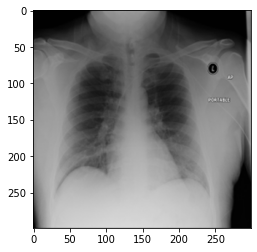

In [8]:
# Random sample

sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [9]:
# Split

train, valid = train_test_split(df, test_size = .33, shuffle = True, random_state=42, stratify=df['label'])
train, test = train_test_split(train, test_size = .01, shuffle = True, random_state=42, stratify=train['label'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, valid.shape, test.shape

((11639, 2), (5792, 2), (118, 2))

In [10]:
# Image preprocessing

train_data_gen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20, 
                                    shear_range=0.1,  
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    brightness_range=[.2, .2])

train_generator = train_data_gen.flow_from_dataframe(train, 
                                                     x_col='filename', 
                                                     y_col='label', 
                                                     target_size=(256, 256), 
                                                     class_mode='categorical', 
                                                     batch_size=16)

valid_data_gen = ImageDataGenerator(rescale=1./255)
                                    # rotation_range=20, 
                                    # shear_range=0.1,  
                                    # horizontal_flip=True,
                                    # width_shift_range=0.1,
                                    # height_shift_range=0.1,
                                    # brightness_range=[.2, .2])

valid_generator = valid_data_gen.flow_from_dataframe(valid, 
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=(256, 256),
                                                     class_mode='categorical',
                                                     batch_size=16)

Found 11639 validated image filenames belonging to 3 classes.
Found 5792 validated image filenames belonging to 3 classes.


In [11]:
base_model = ResNet50(input_shape=(256, 256, 3), weights=None, include_top=False)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = AveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(3, activation='softmax')(x)

# outputs = base_model.output
# outputs = GlobalMaxPooling2D()(outputs)
# outputs = Dense(1024, activation='relu')(outputs) 
# outputs = Dense(1024, activation='relu')(outputs) 
# outputs = Dense(512, activation='relu')(outputs) 
# outputs = Dense(2, activation= 'sigmoid')(outputs)

model = Model(inputs = base_model.input, outputs = x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='auto', verbose = 1, patience = 5)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='auto', save_best_only=True)

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

class_weight = {0: 10192/10192, 1: 10192/6012, 2: 10192/1345}

In [13]:
epochs = 30
train = model.fit(train_generator, 
                    validation_data = valid_generator, 
                    verbose = 1, 
                    epochs=epochs, 
                    callbacks = [early_stopping, checkpoint], 
                    class_weight = class_weight)

Epoch 1/30
728/728 [==============================] - 241s 314ms/step - loss: 1.7141 - accuracy: 0.5377 - val_loss: 0.8831 - val_accuracy: 0.6447
Epoch 2/30
728/728 [==============================] - 219s 301ms/step - loss: 1.4179 - accuracy: 0.6062 - val_loss: 0.8833 - val_accuracy: 0.7137
Epoch 3/30
728/728 [==============================] - 226s 311ms/step - loss: 1.2784 - accuracy: 0.6368 - val_loss: 1.0315 - val_accuracy: 0.7212
Epoch 4/30
728/728 [==============================] - 219s 300ms/step - loss: 1.1957 - accuracy: 0.6563 - val_loss: 1.3107 - val_accuracy: 0.7063
Epoch 5/30
728/728 [==============================] - 219s 301ms/step - loss: 1.1408 - accuracy: 0.6765 - val_loss: 1.1594 - val_accuracy: 0.7436
Epoch 6/30
728/728 [==============================] - 219s 300ms/step - loss: 1.1216 - accuracy: 0.6822 - val_loss: 1.2737 - val_accuracy: 0.7371
Epoch 7/30
728/728 [==============================] - 220s 302ms/step - loss: 1.0911 - accuracy: 0.6886 - val_loss: 1.2407 -

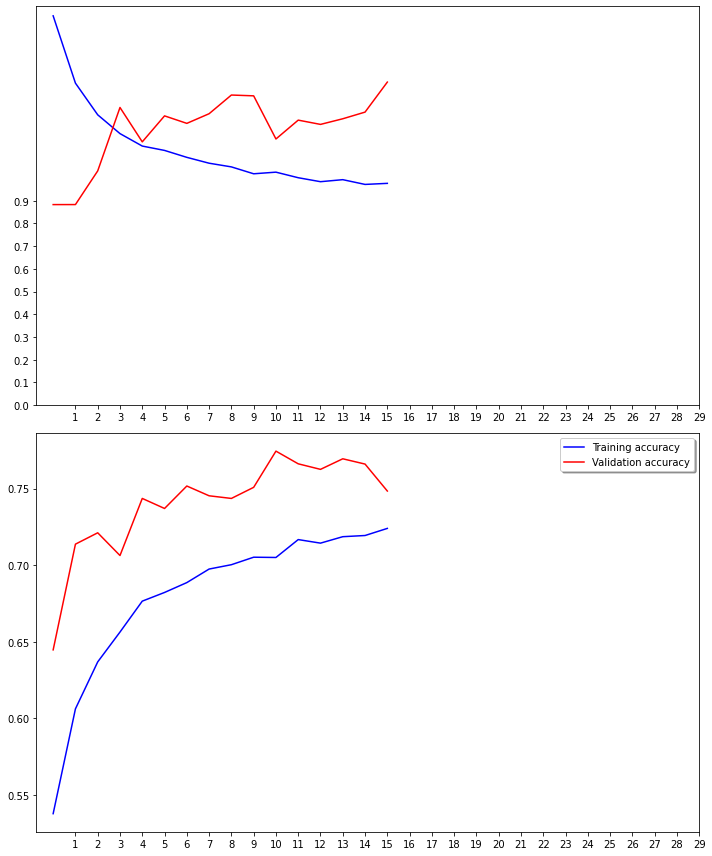

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
ax1.plot(train.history['loss'], color='b', label="Training loss")
ax1.plot(train.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(train.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [33]:
best_model = tf.keras.models.load_model('best_model.h5')

True value is : 정상 
Prediction is : 정상


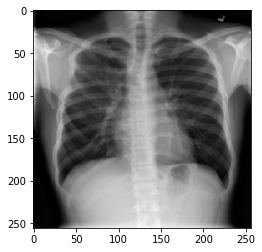

In [63]:
sample = random.choice(test.index)
img_dir = test.loc[sample][0]
img_label = test.loc[sample][1]

true = ''
if img_label == '0':
  true = '정상'
# if img_label == '0':
#   true = '불투명'
else:
  true = '폐렴'

image = load_img(img_dir, target_size=(256, 256))
img = img_to_array(image)
img = img.reshape((1, 256, 256, 3))

result = best_model.predict(img)
result
result = np.argmax(result, axis = -1)

pred = ''
if result == 0:
  pred = '정상'
# if result == 0:
#   pred = '불투명'
else:
  pred = '폐렴'

print(f'True value is : {true} \nPrediction is : {pred}')
plt.imshow(image);
